In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Generate nonlinear data -----
np.random.seed(0)
N = 100
x = np.linspace(-3, 3, N)
true_w = np.array([1, 1])  # true model: y = x²
y = true_w[0] * x**2 + true_w[1] + 0.5 * np.random.randn(N)  # noisy observations

# Model: y_pred = w0*x^2 + w1
def predict(w, x):
    return w[0] * x**2 + w[1]

# Gradient of loss (1/2N * sum (y_pred - y)^2)
def grad_f(w, x, y):
    y_pred = predict(w, x)
    error = y_pred - y
    grad0 = np.mean(error * x**2)
    grad1 = np.mean(error)
    return np.array([grad0, grad1])

# Compute MSE
def mse_loss(w, x, y):
    return np.mean((predict(w, x) - y) ** 2)

# ----- Adam optimizer -----
def adam_optimizer(x, y, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8,
                   epochs=3000, grad_noise=0.0, size = 1):
    w = np.zeros(2)
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    losses = []
    for t in range(1, epochs + 1):
        idx = np.random.choice(len(x), size=size)
        grad = grad_f(w, x[idx], y[idx])
        # grad += grad_noise * np.random.randn(*grad.shape)
        # Adam update
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
        losses.append(mse_loss(w, x, y))
    return w, np.array(losses)

# ----- Regular SGD optimizer -----
def sgd_optimizer(x, y, lr=0.05, epochs=3000, grad_noise=0.0, size = 1):
    w = np.zeros(2)
    losses = []
    for t in range(1, epochs + 1):
        # choose random x and y for gradient calculation
        idx = np.random.choice(len(x), size=size)
        grad = grad_f(w, x[idx], y[idx])
        # grad += grad_noise * np.random.randn(*grad.shape)
        w -= lr * grad
        losses.append(mse_loss(w, x, y))
    return w, np.array(losses)

# ----- Run experiments -----
noise_levels = [0.0]
colors = ['r', 'g', 'b']
size = 1
epochs = 500

adam_fits, sgd_fits = [], []
adam_losses, sgd_losses = [], []

for nl in noise_levels:
    w_adam, loss_adam = adam_optimizer(x, y, epochs=epochs, grad_noise=nl, size=size)
    w_sgd, loss_sgd = sgd_optimizer(x, y, epochs=epochs, grad_noise=nl, size=size)
    adam_fits.append((nl, w_adam))
    sgd_fits.append((nl, w_sgd))
    adam_losses.append((nl, loss_adam))
    sgd_losses.append((nl, loss_sgd))

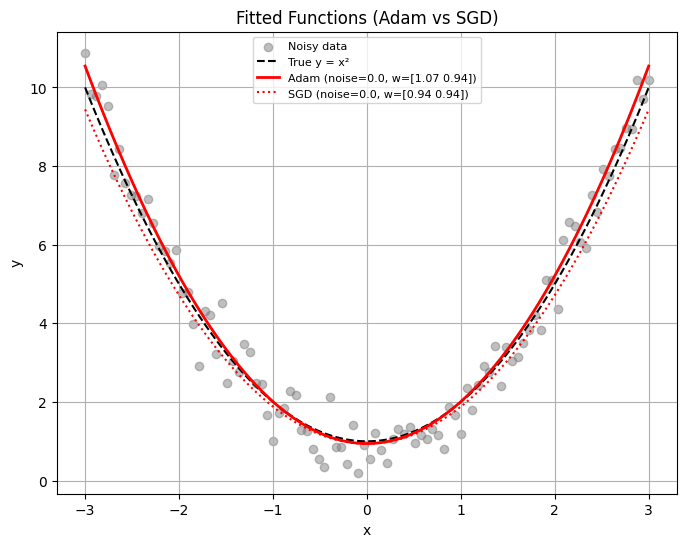

In [23]:


plt.figure(figsize=(8, 6))

# (1) Function fits
plt.scatter(x, y, color='gray', alpha=0.5, label='Noisy data')
plt.plot(x, true_w[0] * x**2 + true_w[1], 'k--', label='True y = x²')

for (nl, w_adam), (nl2, w_sgd), color in zip(adam_fits, sgd_fits, colors):
    plt.plot(x, predict(w_adam, x), color=color, lw=2,
                 label=f'Adam (noise={nl}, w={w_adam.round(2)})')
    plt.plot(x, predict(w_sgd, x), color=color, ls=':',
                 label=f'SGD (noise={nl}, w={w_sgd.round(2)})')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Functions (Adam vs SGD)')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


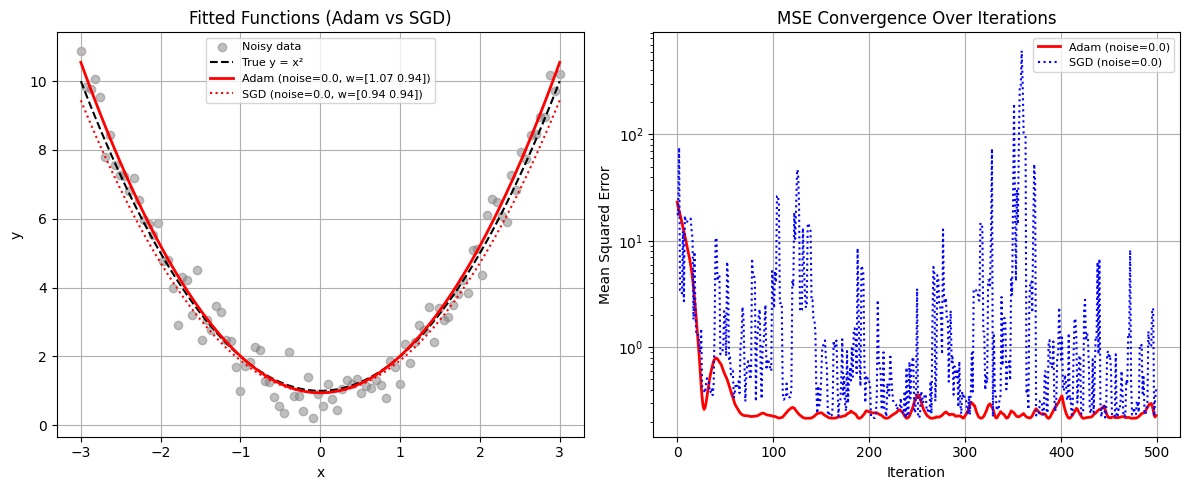

In [24]:
# ----- Plot results -----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (1) Function fits
axes[0].scatter(x, y, color='gray', alpha=0.5, label='Noisy data')
axes[0].plot(x, true_w[0] * x**2 + true_w[1], 'k--', label='True y = x²')

for (nl, w_adam), (nl2, w_sgd), color in zip(adam_fits, sgd_fits, colors):
    axes[0].plot(x, predict(w_adam, x), color=color, lw=2,
                 label=f'Adam (noise={nl}, w={w_adam.round(2)})')
    axes[0].plot(x, predict(w_sgd, x), color=color, ls=':',
                 label=f'SGD (noise={nl}, w={w_sgd.round(2)})')

axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Fitted Functions (Adam vs SGD)')
axes[0].legend(fontsize=8)
axes[0].grid(True)

# (2) MSE convergence
for (nl, loss_adam), (nl2, loss_sgd), color in zip(adam_losses, sgd_losses, colors):
    axes[1].plot(loss_adam, color=color, lw=2, label=f'Adam (noise={nl})')
    axes[1].plot(loss_sgd, color="b", ls=':', label=f'SGD (noise={nl})')

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('MSE Convergence Over Iterations')
axes[1].set_yscale('log')
axes[1].legend(fontsize=8)
axes[1].grid(True)

plt.tight_layout()
plt.show()
